In [1]:
import yfinance as yf
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
from sklearn.preprocessing import MinMaxScaler
import pandas_ta as ta
from datetime import date
from datetime import timedelta

training_start_time = time.time()
# data_start_date = "2020-03-19"
# data_end_date = "2023-03-19"

today = date.today()
end_d = today + timedelta(days=1)
data_end_date = end_d.strftime("%Y-%m-%d")
start_date = today - timedelta(days=1095)
data_start_date = start_date.strftime("%Y-%m-%d")

symbol = 'XRP-USD'
df_data = yf.download(symbol, start=data_start_date, end=data_end_date)

[*********************100%***********************]  1 of 1 completed


In [2]:
def move_close_to_first_column(df_data):
    df_data.drop(columns=['Adj Close'], inplace=True)
    close_price_column = df_data.pop('Close')
    df_data.insert(0, 'Close', close_price_column)
    return df_data

In [3]:
def prepare_ti_dataset(df_data):
    df_data.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
    CustomStrategy = ta.Strategy(
        name="Momo and Volatility",
        description="SMA 5, SMA 10, SMA 20, SMA 30, SMA 50, WMA 10, WMA 20, WMA 30, RSI, EMA, MACD",
        ta=[
            {"kind": "sma", "length": 5},
            {"kind": "sma", "length": 10},
            {"kind": "sma", "length": 20},
            {"kind": "sma", "length": 30},
            {"kind": "sma", "length": 50},
            {"kind": "wma", "length": 10},
            {"kind": "wma", "length": 20},
            {"kind": "wma", "length": 30},
            {"kind": "rsi"},
            {"kind": "ema"},
            {"kind": "macd", "fast": 8, "slow": 21},
        ]
    )

    df_data.ta.strategy(CustomStrategy)
    df_data = df_data.dropna()
    return df_data

In [4]:
def prepare_combined_dataset(df_data):
    df_data.drop(columns=['Open', 'Volume'], inplace=True)
    CustomStrategy = ta.Strategy(
        name="Basic features and technical indicators",
        description="WMA 20, WMA 30, MACD",
        ta=[
            {"kind": "wma", "length": 20},
            {"kind": "wma", "length": 30},
            {"kind": "macd", "fast": 8, "slow": 21},
        ]
    )

    df_data.ta.strategy(CustomStrategy)
    df_data = df_data.dropna()
    return df_data

In [5]:
df_data = move_close_to_first_column(df_data)
# df_data = prepare_ti_dataset(df_data)
# df_data = prepare_combined_dataset(df_data)

In [6]:
prediction_days = int(len(df_data)*0.2)

df_train = df_data[:len(df_data) - prediction_days]
df_test = df_data[len(df_data)-prediction_days:]

In [7]:
def dataset_generator(dataset):
    dataX = dataset.loc[:, dataset.columns != 'Close']
    dataY = dataset['Close']
    
    return dataX, dataY

In [8]:
trainX, trainY = dataset_generator(df_train)
testX, testY = dataset_generator(df_test)

In [9]:
# ARMAX
model = ARIMA(endog=trainY, exog=trainX, order=[30,0,1], freq='D')
model_fit = model.fit()
print(model_fit.summary())

training_time = time.time() - training_start_time

C:\Users\Oleksii_Avdieiev\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Oleksii_Avdieiev\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  877
Model:                ARIMA(30, 0, 1)   Log Likelihood                2166.651
Date:                Sun, 13 Aug 2023   AIC                          -4259.302
Time:                        16:59:25   BIC                          -4082.572
Sample:                    08-13-2020   HQIC                         -4191.706
                         - 01-06-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025   1.49e-24   1.69e+21      0.000       0.003       0.003
Open          -0.5196   1.39e-24  -3.74e+23      0.000      -0.520      -0.520
High           0.8523   1.59e-24   5.37e+23      0.0

In [10]:
# Out-of-sample prediction
predicting_start_time = time.time()
exog_d = testX
predicted_price = model_fit.predict(exog=exog_d, start=exog_d.index[0], end=exog_d.index[-1])

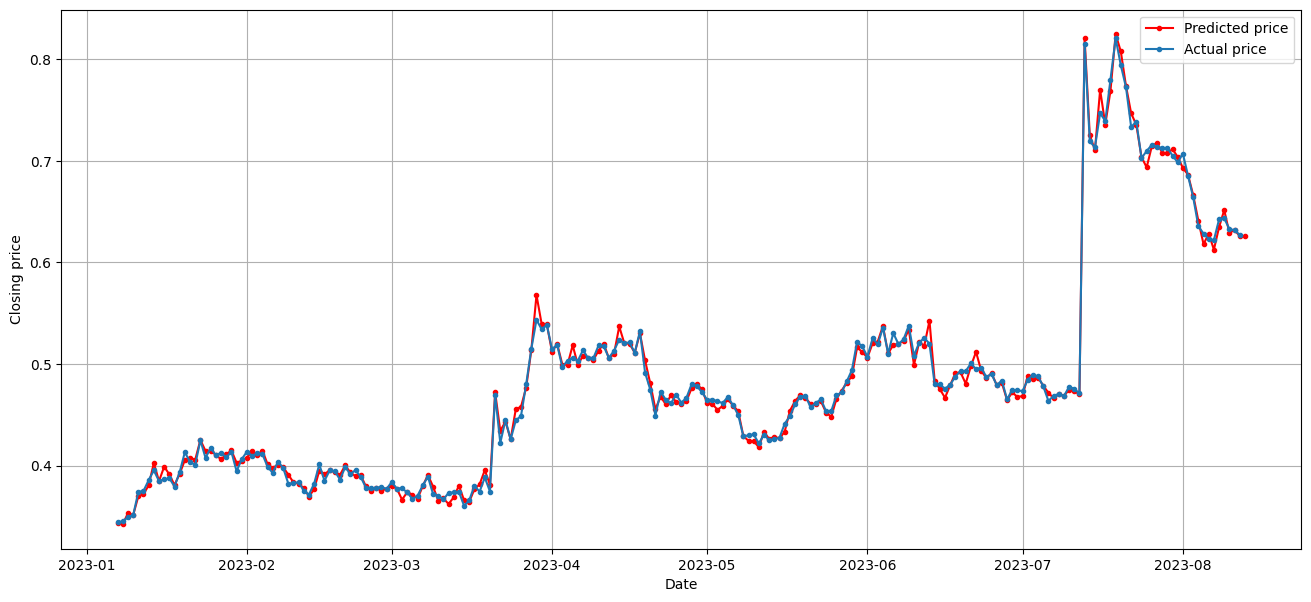

In [11]:
date_range = testY.index
plt.figure(figsize=(16,7))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing price')

actual_prices = testY.copy()
actual_prices[-1] = np.nan

plt.plot(date_range, predicted_price, 'r', marker='.', label='Predicted price')

plt.plot(date_range, actual_prices, marker='.', label='Actual price')

plt.legend()
plt.show()

In [12]:
predicting_time = time.time() - predicting_start_time

# report performance
model_predictions = predicted_price
testing_data = testY
mape = np.mean(np.abs(np.array(model_predictions) - np.array(testing_data))/np.abs(testing_data))
mape_percentage = mape * 100
model_accuracy = 100 - mape_percentage
rmse = math.sqrt(mean_squared_error(testing_data, predicted_price))

print('MAPE: %.2f %%' % mape_percentage)
print('Model accuracy: %.2f %%' % model_accuracy)
print('RMSE: %.3f' % rmse)
print('Training time: %.2f in seconds' % training_time)
print('Predicting time: %.2f in seconds' % predicting_time)

MAPE: 0.90 %
Model accuracy: 99.10 %
RMSE: 0.006
Training time: 16.72 in seconds
Predicting time: 0.28 in seconds
